ライダーのセンサーデータ200mm

In [4]:
import os
import sys

import pandas as pd

filepath = os.path.join(os.getcwd(), "sensor_data", "sensor_data_200.txt")
print("sensor_data_200.txt path", filepath)
data = pd.read_csv(filepath, 
                    delimiter=" ",
                    header=None,
                    names=("date", "time", "ir", "lidar"))

data

sensor_data_200.txt path /home/inoue/Desktop/MyGithub/Book_StatisticsRobotics/sensor_data/sensor_data_200.txt


,date,time,ir,lidar
0,20180122,95819,305,214
1,20180122,95822,299,211
2,20180122,95826,292,199
3,20180122,95829,321,208
4,20180122,95832,298,212
...,...,...,...,...
58983,20180124,120023,313,208
58984,20180124,120026,297,200
58985,20180124,120030,323,204
58986,20180124,120033,326,207


In [5]:
print(data["lidar"][0:5])

0    214
1    211
2    199
3    208
4    212
Name: lidar, dtype: int64


可視化と規則性の確認

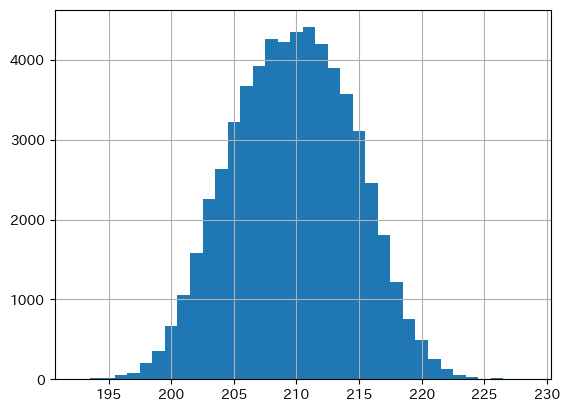

In [6]:
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

rng = max(data["lidar"]) - min(data["lidar"])
data["lidar"].hist(bins=rng, align='left')
plt.show()

In [7]:
# 推定値
mean1 = sum(data['lidar'].values) / len(data['lidar'].values)
mean2 = data['lidar'].mean()
print(mean1)
print(mean2)

209.73713297619855
209.73713297619855


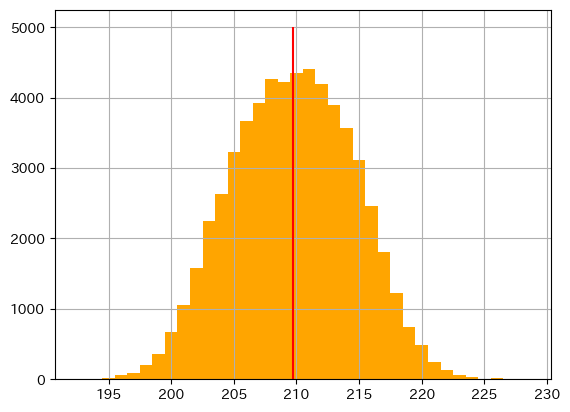

In [8]:
data['lidar'].hist(bins=rng, color='orange', align='left')
plt.vlines(mean1, ymin=0, ymax=5000, color='red')
plt.show()

標本分散と不偏分散
+ 標本分散はサンプリング数Nが小さい時，本来のばらつきより小さく見積もられてしまう.
+ 不偏分散で是正する

In [9]:
# 定義より
lidar = data['lidar']
zs = lidar.values
mean = sum(zs) / len(zs)
diff_squre = [(z - mean)**2 for z in zs]

sampling_var = sum(diff_squre) / len(zs)
unbiased_var = sum(diff_squre) / (len(zs) - 1)

print('標本分散', sampling_var)
print('不偏分散', unbiased_var)

標本分散 23.407709770274106
不偏分散 23.40810659855441


In [10]:
# pandas
pd_sampling_var = lidar.var(ddof=False) # 標本分散
pd_default_var = lidar.var() # 不偏分散(default)

print('標本分散', pd_sampling_var)
print('不偏分散', pd_default_var)

標本分散 23.4077097702742
不偏分散 23.408106598554504


In [11]:
# numpy
import numpy as np

np_default_var = np.var(zs) # 標本分散(default)
np_unbiased_var = np.var(zs, ddof=1) # 不偏分散

print('標本分散', np_default_var)
print('不偏分散', np_unbiased_var)

標本分散 23.4077097702742
不偏分散 23.408106598554504


In [12]:
# 標準偏差
import math

stddev1 = math.sqrt(sampling_var)
stddev2 = math.sqrt(unbiased_var)

pd_stddev = lidar.std()

print('標準偏差[1]', stddev1)
print('標準偏差[2]', stddev2)
print('標準偏差[pandas]', pd_stddev)

標準偏差[1] 4.838151482774605
標準偏差[2] 4.83819249292072
標準偏差[pandas] 4.838192492920729


ライダーデータの確率分布

In [20]:
from email import header

freqs = pd.DataFrame(data['lidar'].value_counts())
freqs.transpose() # 横向き出力

lidar,211,210,208,209,212,207,213,206,214,205,...,197,196,223,224,226,195,194,193,227,229
count,4409,4355,4261,4228,4201,3920,3897,3674,3572,3225,...,84,59,55,32,15,13,10,4,3,1


In [23]:
freqs['probs'] = freqs['count'] / len(data['lidar']) # 確率分布
freqs.transpose()

lidar,211,210,208,209,212,207,213,206,214,205,...,197,196,223,224,226,195,194,193,227,229
count,4409.000000,4355.000000,4261.000000,4228.000000,4201.000000,3920.000000,3897.000000,3674.000000,3572.000000,3225.000000,...,84.000000,59.000,55.000000,32.000000,15.000000,13.00000,10.00000,4.000000,3.000000,1.000000
probs,0.074744,0.073829,0.072235,0.071676,0.071218,0.066454,0.066064,0.062284,0.060555,0.054672,...,0.001424,0.001,0.000932,0.000542,0.000254,0.00022,0.00017,0.000068,0.000051,0.000017


In [24]:
# 確率分布の和
sum(freqs['probs'])

1.0

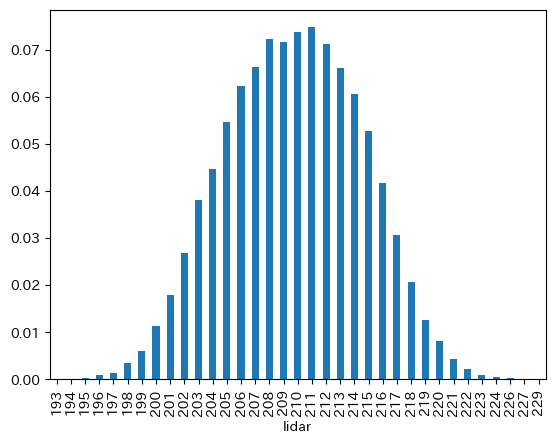

In [25]:
freqs['probs'].sort_index().plot.bar()
plt.show()

確率分布を用いたシミュレーション

In [29]:
# N - 1 回目までのデータに基づく確率分布からN回目のデータをサンプリング
def drawing():
    return freqs.sample(n=1, weights='probs').index[0] # 

drawing()

206

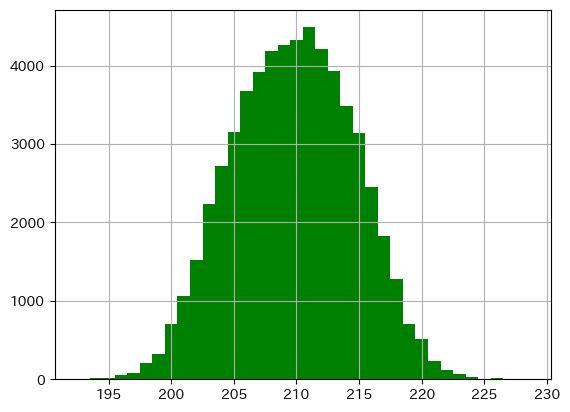

In [30]:
# サンプリングによるヒストグラムの作成
samples = [ drawing() for _ in range(len(data)) ]
simulated = pd.DataFrame(samples, columns=['lidar'])
p = simulated['lidar']
p.hist(bins=max(p)-min(p), color='green', align='left')
plt.show()

ガウス分布の当てはめ

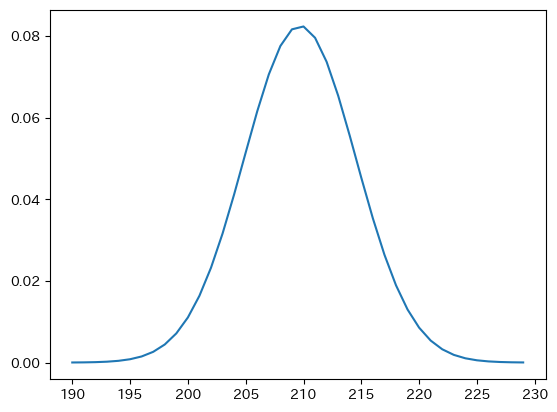

In [33]:
# 標本モデル
def p(z, mu=209.7, dev=23.4):
    return math.exp(-(z - mu) ** 2 / (2 * dev)) / math.sqrt(2 * math.pi * dev)

# 尤度(標本モデル)
xs = range(190, 230)
ys = [p(x) for x in xs]
plt.plot(xs, ys)
plt.show()

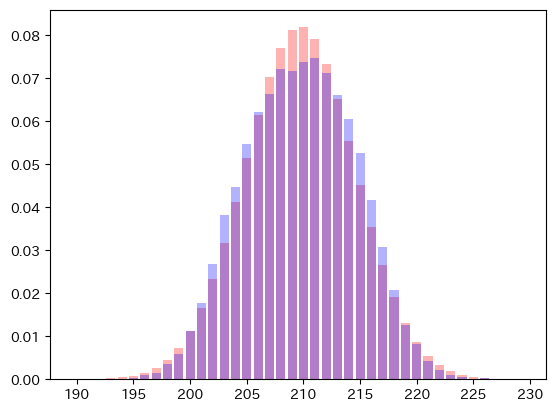

In [34]:
# 確率密度から区間widthで確率を出力
def prob(z, width=0.5):
    return width * (p(z - width) + p(z + width))

ps = [ prob(x) for x in xs ]
plt.bar(xs, ps, color='red', alpha=0.3) # 標本モデルによる確率分布(赤)
f = freqs['probs'].sort_index() # ヒストグラム
plt.bar(f.index, f.values, color='blue', alpha=0.3)
plt.show()